In [1]:
# Standard libraries
import sys
import math
import random
import time
import os

# Third-party imports
import numpy as np
import pandas as pd
import pickle as pkl
import json

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

import keras_tuner as kt

import importlib
from yapf.yapflib.yapf_api import FormatCode
import GPUtil

# Project imports
import ephesus
import utils
from const import *

#### GPU Setup

In [2]:
# Specific GPUs
desir_gpus = [1,2]
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices([gpus[i] for i in desir_gpus], 'GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
mirro_strat = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


#### Data Preprocessing

In [8]:
# Find the most recent file in injec_curve
datas = utils.retur_most_recen(f'{xom_data_path}padde_cuts/')
# datas = 'padde_cuts-34745-2850-6998.pkl'
print(f'Most recent file: {datas}')

with open(f'{xom_data_path}padde_cuts/{datas}','rb') as f:
    raw_x_data = pkl.load(f)

NameError: name 'uti3s' is not defined

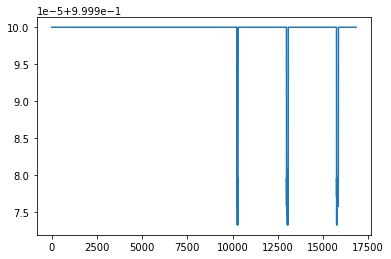

In [16]:
plt.plot(raw_x_data[20000, -1, 1]['moon_signa'])

In [4]:
# Dataset composition setup
DETEC_TYPE = 'plane_moon_cut_injec'
NUMBE_RELEV = 2000
NUMBE_IRREL = 2000

In [5]:
# Separate full dataset into relevant and irrelevant components
full_relev_index = []
for i in range(len(raw_x_data)):
    if raw_x_data[i, -1, 1][DETEC_TYPE]:
        full_relev_index.append(i)
        
# Take a random sample of a relevant
relev_index = random.sample(full_relev_index, NUMBE_RELEV)
relev_curve = np.copy(raw_x_data[relev_index])
# Take a random sample of a irrelevant
irrel_curve = np.delete(raw_x_data, full_relev_index, axis=0)
irrel_curve = irrel_curve[utils.retur_rando_sampl(NUMBE_IRREL, len(irrel_curve))]

# Shuffle the order of the data
rando_shuff_x_data = np.concatenate((relev_curve, irrel_curve), axis=0)
np.random.shuffle(rando_shuff_x_data)

# Normalize the data from 0 to 1
norma_full_x_data = np.copy(rando_shuff_x_data)
x_data = np.copy(rando_shuff_x_data[:, :-1, 1].astype(float))

for i in range(len(x_data)):
    chang_slots = np.where(x_data[i] != 0)[0]
    x_data[i, chang_slots] = utils.norma_data(x_data[i, chang_slots])
    norma_full_x_data[i, :-1, 1] = x_data[i]

x_data = np.expand_dims(x_data, 2)

# Create the corresponding y dataset
y_data = np.zeros(len(norma_full_x_data))
for i in range(len(norma_full_x_data)):
    y_data[i] = norma_full_x_data[i, -1, 1][DETEC_TYPE]

print(
    f'{sum(y_data)/len(y_data):.2%} of the dataset contains a full injection')

50.00% of the dataset contains a full injection


In [6]:
# Split the data into training and testing

stop = len(x_data) - len(y_data) % 100
split = int(stop * 0.7)
    
x_train = np.array(x_data[:split])
full_x_train = norma_full_x_data[:split]
x_test = np.array(x_data[split:stop])
full_x_test = norma_full_x_data[split:stop]
y_train = y_data[:split]
y_test = y_data[split:stop]

In [7]:
# Remove non-full batches (because they cause problems)
BATCH_SIZE = 100

# If no remainder, skip
if x_train.shape[0] % BATCH_SIZE:
    x_train = x_train[:-(x_train.shape[0] % BATCH_SIZE)]
    full_x_train = full_x_train[:-(full_x_train.shape[0] % BATCH_SIZE)]
    y_train = y_train[:-(y_train.shape[0] % BATCH_SIZE)]

if x_test.shape[0] % BATCH_SIZE:
    x_test = x_test[:-(x_test.shape[0] % BATCH_SIZE)]
    full_x_test = full_x_test[:-(full_x_test.shape[0] % BATCH_SIZE)]
    y_test = y_test[:-(y_test.shape[0] % BATCH_SIZE)]

In [8]:
# Baseline calculations for email updates
# Baseline accuracy, precision, and recall are all the same
basel_value = sum(y_test) / len(y_test) 
if basel_value < 0.5:
    basel_value = 1 - basel_value

### Training

In [9]:
# Log Directory

# Open previously used tuner
log_direc = f'{main_path}moon/keras_tuner/14-05-2022_16:53:21_kt'
PROJE_NAME = 'exomo_rnn'
try:
    os.mkdir(f'{log_direc}/deep_train')
except FileExistsError:
    pass

#### Tuner Opening

In [10]:
###

In [11]:
###

In [12]:
# Open the models

model_files = os.listdir(f'{log_direc}/redun_model')

In [13]:
score_file = []
for curre_file in model_files:
    score_file.append([int(curre_file.split('.')[1]), curre_file])
score_file.sort(reverse=True)
# Take the top tenth of models
score_file = score_file[:len(score_file)//10]
# Extract only the file name
deep_train = []
for trial_file in score_file:
    deep_train.append(f'{log_direc}/redun_model/{trial_file[1]}')

In [10]:
# Max number of epochs
EPOCH = 250
# Early stopping patience
PATIE = 10

In [237]:
# Callbacks

# tensorboard = TensorBoard(log_dir=f'{main_path}tensorboard/{datas}_{int(time.time())}')
# resto_valid_accur = utils.resto_best_valid_accur()
# deep_train_model_name = ''
# resto_valid_accur = ModelCheckpoint(f'{log_direc}/deep_train/curre_model.pb', 
                                    # monitor='val_accuracy', save_best_only=True)
early_stopp = EarlyStopping(monitor='val_accuracy', patience=PATIE, restore_best_weights=True)

callb = [early_stopp]#, resto_valid_accur]#, tensorboard]

# Dependiencies for custom metrics

depen = {
    'preci': utils.preci,
    'recal':utils.recal
}

# Features for the true/false positive/negative graphs
tp_tn_fp_fn_featu = ['ratio_moon_stell_radiu',
                     'moon_radiu', 
                     'stell_radiu', 
                     'curve_injec', 
                     'plane_moon_cut_injec']

In [252]:
importlib.reload(utils)

<module 'utils' from '/home/rfradkin/xom/py_script/utils.py'>

In [253]:
a = '/data/scratch/data/moon/keras_tuner/14-05-2022_16:53:21_kt/deep_train/t:1_va:0.541.pb'

In [254]:
%%capture
utils.graph_tp_tn_fp_fn(predi, full_x_test, save_figur_path=a, highl_injec=True,
                  featu=tp_tn_fp_fn_featu);

In [ ]:
%%capture
# Capture used to supress graph_tp_tn_fp_fn output
for model_file in deep_train:
    with mirro_strat.scope(): 
        metri = ["accuracy", utils.preci, utils.recal]
        model = tf.keras.models.load_model(model_file,custom_objects=depen)
        optim = tf.keras.optimizers.Nadam(learning_rate=model.optimizer.get_config()['learning_rate'],
                                          decay=model.optimizer.get_config()['decay'])
        model.compile(loss='BinaryCrossentropy',
              optimizer=optim,
              metrics=metri)
    resul = model.fit(x_train,
                    y_train,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    callbacks=callb,
                    validation_data=(x_test, y_test))
    save_path = f'{log_direc}/deep_train'
    model_name = f"{model_file.split('/')[-1].split('0')[0]}{max(resul.history['val_accuracy']):.3}"
    full_model_path = f'{save_path}/{model_name}'
    model.save(full_model_path)
    predi = model.predict(x_test).squeeze()
    graph_tp_tn_fp_fn(predi, 
                      full_x_test, 
                      save_figur_path=full_model_path,
                      show_figur=False,
                      featu=tp_tn_fp_fn_featu)

#### Formatting